### Table of Contents

* [View Data Imbalance - Rated vs. Unrated](#Imbalance)
* [Models](#Models)
    * [Mixing Reviews To CLassify - Train - Validation](#TrainValidation)
        * [Observations](#TrainValidationobs)
    * [Using Only Rated Reviews To Classify Unrated Reviews](#TestTrain)
        * [Observations](#TestTrainobs)
* [Conclusions](#Conclusions)    


# libraries

In [10]:
import pandas as pd
import numpy as np
import pickle
import sklearn
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix

In [11]:
with open('./data/df_reviews.pickle', 'rb') as f:
    df_reviews = pickle.load(f)

df_reviews_nonTwitter = df_reviews[df_reviews['Source']!='twitter']
df_reviews_twitter = df_reviews[df_reviews['Source']=='twitter']

# View Rated vs. Unrated Counts  <a class="anchor" id="Imbalance"></a>

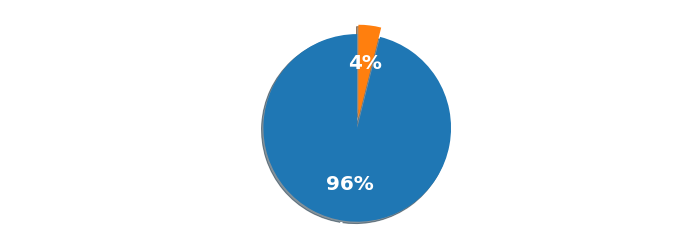

In [12]:
TotalRatedReviews = len(df_reviews_nonTwitter)
TotalNonRatedReviews = len(df_reviews_twitter)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = "Rated Reviews 'Grocery Sites'", "Twitter Reviews - Not Rated"
sizes = [TotalRatedReviews, TotalNonRatedReviews]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90, textprops={'fontsize': 20, 'color':'white', 'weight':'heavy'})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [13]:
print(f'Reviews containing a rating from reviewers : {TotalRatedReviews}')
print(f'Reviews from unrated sources (Twitter in our case) : {TotalNonRatedReviews}')

Reviews containing a rating from reviewers : 1744
Reviews from unrated sources (Twitter in our case) : 71


# RF Classification - Mixing Twitter and Retailer Reviews To Create Model
<a class="anchor" id="Models"></a>

## Mixing Reviews (Retail & Precoded Twitter) To Create Model  <a class="anchor" id="TrainValidation"></a>

In [14]:
 # Rf Params For Gridsearch
# X = df_reviews['TextClean4']
X = df_reviews['TextClean3']
y = df_reviews['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
# class_weights
    
hyp_params_rf = [{
'criterion': ['gini'],
'max_depth': [1], 
'n_estimators': [275], 
'min_samples_split': [2], 
'min_samples_leaf':[400], 
'max_features': [.2],# 1 
'oob_score':[True],
'bootstrap': [True],
'random_state':[0],
'class_weight':[{0:.58, 1:3.6}]
}]    


vectorizer = TfidfVectorizer(norm='l1')

X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_test_tfidf = vectorizer.transform(X_test) # remember to use the original X_train set
X_train_tfidf.shape

estimator = RandomForestClassifier()
gridF = GridSearchCV(estimator=estimator, param_grid=hyp_params_rf, scoring="recall",cv = 10, n_jobs = -1)


Rf_MixedReviewsModel = gridF.fit(X_train_tfidf, y_train)

modelscore_Train = round(Rf_MixedReviewsModel.score(X_train_tfidf, y_train),2)
modelscore_Test = round(Rf_MixedReviewsModel.score(X_test_tfidf, y_test),2)

print(f'Train Score: {modelscore_Train}')
print(f'Validation Score: {modelscore_Test}')   
# print("Best Parameters: \n{}\n".format(bestF.best_params_))


Train Score: 0.82
Validation Score: 0.81


In [15]:
predictions = Rf_MixedReviewsModel.predict(X_test_tfidf)
print (f'Accuracy: {round(accuracy_score(y_test, predictions),2)}')
print (f'F1 score: {round(f1_score(y_test, predictions),2)}')
print (f'Recall: {round(recall_score(y_test, predictions),2)}')
print (f'Precision: {round(precision_score(y_test, predictions),2)}')
# print (f'\n clasification report: \n  {classification_report(y_test,predictions)}')
# print (f'\n confussion matrix: \n {confusion_matrix(y_test, predictions)}')


Accuracy: 0.63
F1 score: 0.42
Recall: 0.81
Precision: 0.28


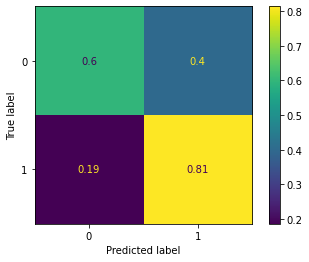

In [16]:
plot_confusion_matrix(Rf_MixedReviewsModel, X_test_tfidf, y_test, normalize="true")  
plt.show()

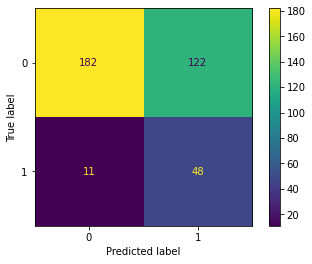

In [17]:
plot_confusion_matrix(Rf_MixedReviewsModel, X_test_tfidf, y_test)  
plt.show()

### Test - Using Mixed Model/Data On Twitter Reviews

In [18]:
# X_train = df_reviews_nonTwitter['TextClean3']
# y_train = df_reviews_nonTwitter['Class']
X_test_Tw = df_reviews_twitter['TextClean3']
y_test_Tw = df_reviews_twitter['Class']

X_test_tfidf_Tw = vectorizer.transform(X_test_Tw)

predictions_TW = Rf_MixedReviewsModel.predict(X_test_tfidf_Tw)

print ('\n TEST \n')
print (f'Accuracy: {round(accuracy_score(y_test_Tw, predictions_TW),2)}')
print (f'F1 score: {round(f1_score(y_test_Tw, predictions_TW),2)}')
print (f'Recall: {round(recall_score(y_test_Tw, predictions_TW),2)}')
print (f'Precision: {round(precision_score(y_test_Tw, predictions_TW),2)}')
# print (f'\n clasification report: \n  {round(classification_report(y_test_Tw,predictions_TW),2)}')
# print (f'\n confussion matrix: \n {round(confusion_matrix(y_test_Tw, predictions_TW),2)}')


 TEST 

Accuracy: 0.51
F1 score: 0.53
Recall: 0.87
Precision: 0.38


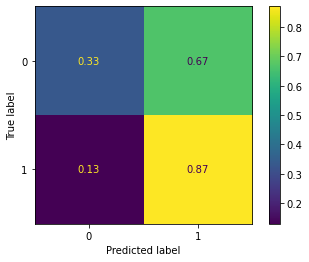

In [19]:
clf = Rf_MixedReviewsModel.best_estimator_
plot_confusion_matrix(clf, X_test_tfidf_Tw, y_test_Tw, normalize="true")  
plt.show()

## Observations <a class="anchor" id="TrainValidationobs"></a> 

Comments: Per the above results by mixing rated and unrated reviews we are able to eliminate overfitting and get recall of 87% on unrated twitter reviews.   This is somewhat expected as the training dataset and the validation set contain some of the exact same reviews.  Did this step as a precursor to the below, using only rated reviews to classify rated reviews.

Why Recall:  For this project, given the business context to minimized missed negative comments, I am selecting recall as my key measure for accuracy/ model effectiveness.

# RF Classification - Using RetailOnly Data On Twitter Reviews <a class="anchor" id="TestTrain"></a>

In [20]:
X_train = df_reviews_nonTwitter['TextClean3']
y_train = df_reviews_nonTwitter['Class']
X_test = df_reviews_twitter['TextClean3']
y_test_Tw1 = df_reviews_twitter['Class']

# class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
# class_weights
    
hyp_params_rf = [{
'criterion': ['gini'],
'max_depth': [1], 
'n_estimators': [500], 
'min_samples_split': [2], 
'min_samples_leaf':[500], 
'max_features': [.2],# 1 
'oob_score':[True],
'bootstrap': [True],
'random_state':[0],
'class_weight':[{0:.58, 1:3.6}]
}]    


vectorizer = TfidfVectorizer(norm='l1')

X_train_tfidf = vectorizer.fit_transform(X_train) # remember to use the original X_train set
X_test_tfidf_TW1 = vectorizer.transform(X_test) # remember to use the original X_train set

estimator = RandomForestClassifier()
gridF = GridSearchCV(estimator=estimator, param_grid=hyp_params_rf, scoring="recall",cv = 10, n_jobs = -1)


Rf_RetailOnlyModel = gridF.fit(X_train_tfidf, y_train)

modelscore_Train = round(Rf_RetailOnlyModel.score(X_train_tfidf, y_train),2)
modelscore_Test = round(Rf_RetailOnlyModel.score(X_test_tfidf_TW1, y_test_Tw1),2)

print(f'Train Score: {modelscore_Train}')
print(f'Test Score: {modelscore_Test}')   
# print("Best Parameters: \n{}\n".format(bestF.best_params_))


Train Score: 0.82
Test Score: 0.83


In [21]:
predictions_TW1 = Rf_RetailOnlyModel.predict(X_test_tfidf_TW1)

print ('\n TEST \n')
print (f'Accuracy: {round(accuracy_score(y_test_Tw1, predictions_TW1),2)}')
print (f'F1 score: {round(f1_score(y_test_Tw1, predictions_TW1),2)}')
print (f'Recall: {round(recall_score(y_test_Tw1, predictions_TW1),2)}')
print (f'Precision: {round(precision_score(y_test_Tw1, predictions_TW1),2)}')



 TEST 

Accuracy: 0.55
F1 score: 0.54
Recall: 0.83
Precision: 0.4


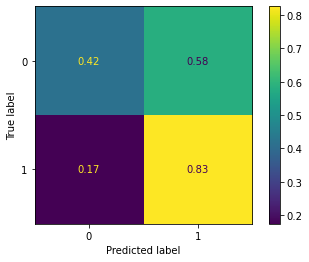

In [22]:
clf = Rf_RetailOnlyModel.best_estimator_
plot_confusion_matrix(clf, X_test_tfidf_TW1, y_test_Tw1, normalize="true")  
plt.show()

## Observations <a class="anchor" id="TestTrainobs"></a> 

Per the above results by only using rated reviews to classify unrated reviews we are able to eliminate overfitting (82% & 83%) and get recall of 83% on unrated twitter reviews.  This is great news as it may allow us to get more reviews from social media sites, that are plump with sentiments and ideas for innovation, but no ability for the reviewing to make a quantified response, positive or negative.  With this model we will be able to at least understand whether a consumer viewed the product as positive or negative.

# Key Word Analysis/ Feature Selection

In [52]:
feature_names = vectorizer.get_feature_names()

dictOfDfs_Importantfeatures = {}
df_feature_importances = pd.concat([pd.DataFrame(feature_names, columns = ["features"]),
                                    pd.DataFrame(np.transpose(Rf_RetailOnlyModel.best_estimator_.feature_importances_), columns = ["coef"])],axis = 1)

df_feature_importances["coef"] = df_feature_importances["coef"]
df_feature_importances = df_feature_importances.sort_values(by="coef", ascending=False)
df_feature_importances.head(10)


# import matplotlib
# matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
# ax = df_feature_importances.plot(kind = "barh")
# plt.title("Feature importance using Lasso Model")
# ax.set_yticklabels(df_feature_importances['features']);
# plt.show();

,features,coef
1723,meat,0.480874
1226,good,0.459016
2836,taste,0.060109
0,abilities,0.000000
2153,prior,0.000000
2144,pretending,0.000000
2145,pretzel,0.000000
2146,pretzilla,0.000000
2147,prevent,0.000000
2148,previous,0.000000


Observation:  Given the above three words were used by the model to create the classification

# Conclusions <a class="anchor" id="Conclusions"></a> 

The above model offers the opportunity to avoid having to manually code data captured from social media sites that do not offer the users the ability to enter a rating themselves.  This rating was instrumental in my work as it was the only mechanism for me to sort the data into the required segments, positive and negative.  The segmenting of data into positive and negative was required for maximizing the insights discovered by the topic modeling algorithm.  As mentioned in a previous notebook, the topic modeling algorithm was not finding the topics associated with negative reviews due to being overshadowed by the larger quantities of positive reviews.  This model reduces the need for manual coding and opens the research up to using reviews from the vast number social media sites not specifically designed to capture reviews.  

Why Recall:  As mentioned above, given the business context I believe missing the opportunity to "dig into"/ learn from a negative review is greater than missing the opportunity to learn from positive comments.  Therefore, recall was the priority over precision as my key measure for model accuracy/ effectiveness.  In this context, a false negative (type II error) represents, calling an actual negative review positive, which potentially means missing the opportunity to find innovation ideas from negative product attributes.  Missing this opportunity seems more costly than the alternative, a false positive, which in this case equals misclassifying an actual positive review as a negative (type I error) and thinking positive product attributes are negative.

However, the cost of making either mistake, Type I or Type II, is low as each mistake only represents additional processes and or time spent conducting the hypothetical steps to review and consider how to handle insights gained from either positive or negative reviews.  In reality, innovation can be inspired by both negative and positive sentiments.
